# Image Analysis Code for February Assays

### Loading Packages

In [1]:
import pandas as pd
import time
import skimage
from skimage import io
from skimage.filters import threshold_otsu
from skimage import feature
from skimage import morphology
from skimage import measure
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import cv2
import pathlib
import csv
import seaborn as sns

### Loading file paths

### Loading Metadata

In [2]:
def process_all_imgs():
  # Create directory to store results to insure that naming conventions are consistent
    current_dir = pathlib.Path(input('Enter the file path to the folder containing the images and metadata to be analyzed: '))

    
    automated_results_location = current_dir.joinpath('automated_results')
    automated_results_location.mkdir(exist_ok=True, parents=True)

    
    image_location = current_dir.joinpath('Images')
    metadata_location = current_dir.joinpath('metadata')

    image_metadata_fname = input('Please enter the filename for the image metadata: ')


    batch_metdata_fname = input('Please enter the filename for the batch metadata: ')


    image_metadata_path = metadata_location.joinpath(image_metadata_fname)
    batch_metdata_path = metadata_location.joinpath(batch_metdata_fname)


    image_metadata = pd.read_csv(image_metadata_path)
    batch_metadata = pd.read_csv(batch_metdata_path)

    image_metadata.rename(columns={'Name of individual capturing image:': 'imager',
                       'Date:': 'date',
                       "Image file name:": 'filename',
                       'Is this the pre or post assay image?': 'pre_fin',
                      'Plate number in slot 1:': 'slot1_plate',
                       'Plate number in slot 2:': 'slot2_plate',
                       'Plate number in slot 3:': 'slot3_plate',
                       'Plate number in slot 4:': 'slot4_plate', 
                                 'Compound in slot 1:': 'slot1_compound', 
                                 'Compound in slot 2:': 'slot2_compound', 
                                 'Compound in slot 3:': 'slot3_compound', 
                                 'Compound in slot 4:': 'slot4_compound',}, inplace=True)

    batch_metadata.rename(columns={'Recorder\'s Name:': 'recorder',
                                'Date:': 'date',
                                 'Temperature:': 'temp',
                                'Humidity:': 'humidity',
                                'Date chemotaxis plates were poured:': 'plates_poured',
                                'Worm Strain in Well P:': 'strain_wellP',
                                'Worm Strain in Well Q:.1': 'strain_wellQ',
                                'Worm Strain in Well R:.1': 'strain_wellR',
                                'Worm Strain in Well S:.1': 'strain_wellS',
                                'dates' : 'dates_modified',}, inplace = True )
    batch_metadata['dates_modified'] = batch_metadata['dates_modified'].astype(str)





    return image_location, metadata_location, image_metadata, batch_metadata, automated_results_location

#if __name__ == "__main__":
#        main()

### Load Images

In [3]:
def load_image_data(data_location, prefix, plate_id):

    pre_file = data_location.joinpath(prefix + '_pre' + plate_id + '.tif')
    pre_image = skimage.io.imread(pre_file)
    
    fin_file = data_location.joinpath(prefix + '_fin' + plate_id + '.tif' )
    fin_image = skimage.io.imread(fin_file)

    return pre_image, fin_image

### Cropping image to individual plates and wells

In [24]:
def crop_to_one_plate(pre_image, fin_image, slot_id):
    # select bounds of the slot we're working on now
    if slot_id == 1:
        upper_boundary = 760
        lower_boundary = 6786
        left_boundary = 5440
        right_boundary = 9444
    elif slot_id == 2:
        upper_boundary = 760
        lower_boundary = 6786
        left_boundary = 784 
        right_boundary = 4788
    elif slot_id == 3:
        upper_boundary = 7480
        lower_boundary = 13506
        left_boundary = 784
        right_boundary = 4788
    elif slot_id == 4:
        upper_boundary = 7480
        lower_boundary = 13506
        left_boundary = 5440
        right_boundary = 9444
    else:
        raise ValueError('Lane label not recognized.')

    pre_image = pre_image[upper_boundary:lower_boundary, left_boundary:right_boundary]
    fin_image = fin_image[upper_boundary:lower_boundary, left_boundary:right_boundary]
        
    # Crop larger image to make before and after images the same size
#    x_min = 0
#    x_max = min(pre_image.shape[1], fin_image.shape[1])
#    y_min = 0
#    y_max = min(pre_image.shape[0], fin_image.shape[0])
#    pre_image = pre_image[y_min:y_max, x_min:x_max]
#    fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return pre_image, fin_image

In [4]:
def left_crop_to_one_well(pre_image, fin_image, well_id):
    # select bounds of the lane we're working on now
    Left_boundary = 300
    Right_boundary = 3724
    if well_id == 'P':
        Upper_boundary = 265
        Lower_boundary = 1415
    elif well_id == 'Q':
        Upper_boundary = 1725
        Lower_boundary = 2875
    elif well_id == 'R':
        Upper_boundary = 3165
        Lower_boundary = 4315
    elif well_id == 'S':
        Upper_boundary = 4615
        Lower_boundary = 5765
    fin_image = fin_image[ Upper_boundary:Lower_boundary ,Left_boundary:Right_boundary ]
    pre_image = pre_image[ Upper_boundary:Lower_boundary ,Left_boundary:Right_boundary ]
        
    #print('X-Axis After Crop:' + 'Pre  '+ str(int(pre_image.shape[1])) + ' Fin  ' + str(int(fin_image.shape[1])))
    #print('Y-Axis After Crop:' + 'Pre ' + str(int(pre_image.shape[0])) + ' Fin ' + str(int(fin_image.shape[0])))
    
    # Crop larger image to make before and after images the same size
    #x_min = 0
    #x_max = fin_image.shape[1]
    
    #y_min = 0
    #y_max = fin_image.shape[0] # min(pre_image.shape[0], fin_image.shape[0])
    
    #pre_image = pre_image[y_min:y_max, x_min:x_max]
    #fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return pre_image, fin_image

def right_crop_to_one_well(pre_image, fin_image, well_id):
    # select bounds of the lane we're working on now
    Left_boundary = 190
    Right_boundary = 3614
    if well_id == 'P':
        Upper_boundary = 265
        Lower_boundary = 1415
    elif well_id == 'Q':
        Upper_boundary = 1725
        Lower_boundary = 2875
    elif well_id == 'R':
        Upper_boundary = 3165
        Lower_boundary = 4315
    elif well_id == 'S':
        Upper_boundary = 4615
        Lower_boundary = 5765
    fin_image = fin_image[ Upper_boundary:Lower_boundary , Left_boundary:Right_boundary ]
    pre_image = pre_image[ Upper_boundary:Lower_boundary ,Left_boundary:Right_boundary ]
        
    #print('X-Axis After Crop:' + 'Pre  '+ str(int(pre_image.shape[1])) + ' Fin  ' + str(int(fin_image.shape[1])))
    #print('Y-Axis After Crop:' + 'Pre ' + str(int(pre_image.shape[0])) + ' Fin ' + str(int(fin_image.shape[0])))
    
    # Crop larger image to make before and after images the same size
    #x_min = 0
    #x_max = fin_image.shape[1]
    
    #y_min = 0
    y_max = fin_image.shape[0] # min(pre_image.shape[0], fin_image.shape[0])
    
    #pre_image = pre_image[y_min:y_max, x_min:x_max]
    #fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return pre_image, fin_image


### Connecting the plate ID with its location in the image

In [5]:
def get_plate_id(slot, image_pointer, img_metdat):
    file_name = image_pointer.resolve().stem[:] + '.tif'
    if slot == 1:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot1_plate', 'slot1_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 2:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot2_plate', 'slot2_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 3:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot3_plate', 'slot3_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
    elif slot == 4:
        data_list = img_metdat.loc[img_metdat['filename'] == file_name, ['slot4_plate', 'slot4_compound' ]].values.flatten().tolist()
        plate = data_list[0]
        compound = data_list[1]
        
    return plate, compound

        

In [6]:
def get_strain(prefix, well_id, batch_dat):
    if well_id == 'P':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellP']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'Q':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellQ']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'R':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellR']].values.flatten().tolist()
        strain = strain_l[0]
    elif well_id == 'S':
        strain_l = batch_dat.loc[batch_dat['dates_modified'] == prefix, ['strain_wellS']].values.flatten().tolist()
        strain = strain_l[0]
        
    return strain

### Image alignment function

In [7]:
def alignImages(im1, im2):

    MAX_FEATURES = 400
    GOOD_MATCH_PERCENT = 0.05
  # Detect ORB features and compute descriptors.
    #sift = cv2.xfeatures2d.SIFT_create()
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
   
  # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
   
  # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
 
  # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    #cv2.imwrite('matched/' + str(plate_id) + "matches.jpg", imMatches)
   
  # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
   
  # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
  # Use homography
    height, width = im1.shape
    im1Reg = cv2.warpPerspective(im2, h, (width, height))
    
    #cv2.imwrite('aligned/' + plate_id + 'aligned.tif', im1Reg)
    return im1Reg, h

### Background subtraction and worm ID

In [76]:
def find_worms(pre_image, fin_image):
    feature_find_start = time.time()
    
    ## Subtract background
    bkg_subtract = np.subtract(fin_image.astype('int16'), pre_image.astype('int16'))
    bkg_subtract[bkg_subtract < 0] = 0
    bkg_subtract = bkg_subtract.astype('uint8')
 
    
    ## Threshold to get binary image
    thresh = skimage.filters.threshold_otsu(bkg_subtract)
    binarized = bkg_subtract > thresh
    if thresh <= 13:
        print('Binarization threshold is', str(thresh))

    ## Find features in binary image
    labeled_array, num_features = ndi.label(binarized)
    all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
                                      coordinates='rc')

    filtered_regions = []
    for region in all_regions:
        area = region.area

        if area >= 120 and area <=1000 and region.major_axis_length < 120:
            filtered_regions.append(region)
            #print(area)
    #print(plate_id + well_id + '   ' + str(len(filtered_regions)))
#     print('Worm finding and filtering took', str(int(time.time() - feature_find_start)), 'seconds.')
    return filtered_regions

In [77]:
def save_worm_locations(filename, worms):
    with open(filename, 'w', newline='') as csvfile:
        worm_writer = csv.writer(csvfile, delimiter=',')
        worm_writer.writerow([' ','X','Y']) # header row

        worm_num = 1
        for worm in worms:
            worm_writer.writerow([worm_num, worm.centroid[1], worm.centroid[0]])
            worm_num += 1

### Chemotaxis Calculator

In [10]:
def calc_chemotaxis_index(worm_regions):
    ## Assign features to zones of the plate
#     left_area_boundary = 8700 #int(fin_image.shape[1]/3)
#     right_area_boundary = 12000 #int(2 * (fin_image.shape[1] / 3))
    left_area_boundary = int(3480*2/5) #8000
    right_area_boundary = int(3480*3/5)

    left_side_worms = [worm for worm in worm_regions if worm.centroid[1] <= left_area_boundary]
    middle_worms = [worm for worm in worm_regions 
                    if worm.centroid[1] > left_area_boundary and worm.centroid[1] < right_area_boundary]
    right_side_worms = [worm for worm in worm_regions if worm.centroid[1] >= right_area_boundary]

#                       filtered_regions[[centroid[1] <= left_area_boundary 
#                                         for centroid in filtered_regions['centroid']]]
#     middle_worms = filtered_regions[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
#                                      for centroid in filtered_regions['centroid']]]
#     right_side_worms = filtered_regions[[centroid[1] > right_area_boundary 
#                                          for centroid in filtered_regions['centroid']]]
    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(worm_regions)
    print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))
    
    chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))

#    worm_dif = worms_in_upper_region - worms_in_lower_region
#    worm_sum = worms_in_upper_region + worms_in_lower_region
    
#    try:
#        chemotaxis_index = worm_dif / worm_sum
#    except ZeroDivisionError:
#        chemotaxis_index = 0
#        print(plate_id + well_id)

    #chemotaxis_index = worm_dif / worm_sum

    print('Chemotaxis index is', str(chemotaxis_index))
   
    x_coords = []
    y_coords = []
    for worm in worm_regions:
#         x_sum += worm.centroid[0]
#         y_sum += worm.centroid[1]
        x_coords.append(worm.centroid[0])
        y_coords.append(worm.centroid[1])

    centroid = (sum(x_coords)/len(x_coords), sum(y_coords)/len(y_coords))

    return chemotaxis_index, centroid

In [11]:
class Plate_info:
    def __init__(self, slot, pID):
        self.slot = slot
        self.pID = pID
        #self.compound = compound
        #self.wellP = strainP
        #self.wellQ = strainQ
        #self.wellR = strainR
        #self.wellS = strainS


In [12]:
def capture_data(snum):
    data = Plate_info(snum, input('Enter plate ID: ')) 
                      #input('Enter compound applied to plate: '),
                      #input('Enter strain in well P: '),
                      #input('Enter strain in well Q: '),
                      #input('Enter strain in well R: '),
                      #input('Enter strain in well S: '))
    data = data.__dict__
    return data

In [13]:
def one_image_metdat():
    slots = {}
    for i in range(1,5):
        num = i
        check = user_input(num)
        print(check)
        if check == 'n' or check == 'no':
            break
        else:
            slots[i] = check
    return slots


In [14]:
def user_input(snum):
    answer = input('Is there a plate in slot %d? ' %snum).lower()
    if answer == 'y' or answer == 'yes':
        info = capture_data(snum)
        return info
    elif answer == 'n' or answer == 'no':
        return answer
    else:
        print('Please enter a valid response')
        return user_input(snum)
        


In [15]:
def run_loop(img_loc, batch_loc, img_metdat, batch_dat, auto_loc):

    loop_start = time.time()
    results = []
    for image in img_loc.glob('*fin*.tif'): #image_location.glob('scan*Fin.tif'): #
        plate_start = time.time()
        path = image.resolve()
        prefix = image.stem[0:8]
        suffix = image.stem[12:]
        image_id = image.stem
        print(prefix)


    #    if image.parent.joinpath(prefix + '_' + plate_id + '_pre.tif').exists is False:
    #        raise NameError('No matching pre-image found.')

        # Load the entire image
        pre_image, fin_image = load_image_data(img_loc, prefix, suffix)
        print('Image load took', str(int(time.time()-plate_start)), 'seconds.')

        #pre_aligned, h = alignImages(fin_image, pre_image)
        fin_aligned, h = alignImages(pre_image, fin_image)

        # Crop 4 plate image to single plate
        for i in range(1,5):
            slot_id = i
            pre_cropped_2plate, fin_cropped_2plate = crop_to_one_plate(pre_image, fin_aligned, slot_id) 
            plate_id, compound = get_plate_id(slot_id, path, img_metdat)
            if plate_id == '0':
                break
            else:
                results_list = []
                for well_id in ['P', 'Q', 'R', 'S']:
                    # Process one well at a time
                    if slot_id == 1 or slot_id == 4:
                        pre_cropped_2well, fin_cropped_2well = right_crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id)
                    elif slot_id == 2 or slot_id == 3:
                        pre_cropped_2well, fin_cropped_2well = left_crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id)

                    #pre_aligned, h = alignImages(fin_cropped_2well, pre_cropped_2well)
                    #fin_aligned, h = alignImages(pre_cropped_2well, fin_cropped_2well)
                    #worms = find_worms(fin_aligned, pre_aligned)
                    strain = get_strain(prefix, well_id, batch_dat)

                    worms = find_worms(pre_cropped_2well, fin_cropped_2well)
                    total_worms = len(worms)
                    # Save the results
                    filename = auto_loc.joinpath(prefix + '_' + plate_id + '_' + well_id + '_automatedCounts' + '.csv')
                    save_worm_locations(filename, worms)

                    if total_worms == 0:
                        chemotaxis_index = 'NA'
                    # Calculate chemotaxis index and gather into a dataframe
                        results_dict = {'Image ID' : prefix,
                                        'Slot_id' : slot_id,
                                        'Plate_id': plate_id,
                                        'Strain_id' : strain,
                                        'Compound_id' : compound,
                                        'Well_id': well_id,
                                        'Total_Worms' : total_worms,
                                        'chemotaxis_index': chemotaxis_index,
                                        'centroid_x': centroid[1],
                                        'centroid_y': centroid[0]}
                        results_list.append(results_dict)
                        results.append(results_dict)

                        props = ['area', 'convex_area', 'bbox', 'centroid']
                        worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

                        #plot_worms(worm_df, cropped_fin_image)

                    else:

                        chemotaxis_index, centroid = calc_chemotaxis_index(worms)
                        results_dict = {'Date' : prefix,
                                        'Filename': image_id,
                                        'Well_id': well_id,
                                        'Plate_id': plate_id,
                                        'Strain_id' : strain,
                                        'Compound_id' : compound,
                                        'Total_Worms' : total_worms,
                                        'chemotaxis_index': chemotaxis_index,
                                        'centroid_x': centroid[1],
                                        'centroid_y': centroid[0]}
                        results_list.append(results_dict)
                        results.append(results_dict)

                        props = ['area', 'convex_area', 'bbox', 'centroid']
                        worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

                #results_df = pd.DataFrame(results_list)
                #results_df.to_csv(path_or_buf=results_location.joinpath(prefix + '_' + plate_id + '_chemotaxis_summary.csv'))


            print('Finished', plate_id,'in', str(int(time.time()-plate_start)), 'seconds.')
        all_results_df = pd.DataFrame(results)
        all_results_df.to_csv(path_or_buf=auto_loc.joinpath('bkgsub_all_plates.csv'))
        # results_df = pd.DataFrame(results_list)
        # results_df.to_csv(path_or_buf=base_folder.joinpath('chemotaxis_summary.csv'))
        print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')


In [79]:
def process_one_image_adaptive():
    current_dir = pathlib.Path(input('Enter the path to the folder containing the data to be analyzed:\n'))
    print(current_dir)
    
    automated_results_location = current_dir.joinpath('automated_results')
    automated_results_location.mkdir(exist_ok=True, parents=True)
    
    image_location = current_dir.joinpath('Images')
    print(image_location)
    
    pre_image_loc = image_location.joinpath(input('Enter the name of the pre image file to be analyzed:\n'))
    post_image_loc = image_location.joinpath(input('Enter the name of the post image file to be analyzed:\n'))

    
#    image_to_analyze = skimage.io.imread(image)
    
    metadata = one_image_metdat()
    
    quick_process_adaptive(pre_image_loc, post_image_loc, automated_results_location, metadata)
    
    #for i in range(len(metadata)):
        #lane = i + 1
        #fin_cropped_2plate = crop_to_one_plate(image_to_analyze, lane)
        #io.imshow(fin_cropped_2plate)

In [17]:
def quick_process_adaptive(pre_img_loc, fin_img_loc, auto_loc, metdat):
    
    loop_start = time.time()
    results = []
    bins = 9

#    if image.parent.joinpath(prefix + '_' + plate_id + '_pre.tif').exists is False:
#        raise NameError('No matching pre-image found.')

    # Load the entire image
    pre_image = skimage.io.imread(pre_img_loc)
    fin_image = skimage.io.imread(fin_img_loc)
#    print('Image load took', str(int(time.time()-plate_start)), 'seconds.')

    fin_aligned, h = alignImages(pre_image, fin_image)

    for i in range(len(metdat)):
        slot_id = i + 1
        plate_id = metdat[slot_id]['pID']
        pre_cropped_2plate, fin_cropped_2plate = crop_to_one_plate(pre_image, fin_aligned, slot_id) 
        #plate_id, compound = get_plate_id(slot_id, path, img_metdat)

        results_list = []
        for well_id in ['P', 'Q', 'R', 'S']:
            # Process one well at a time
            if slot_id == 1 or slot_id == 4:
                cropped_pre_image, cropped_fin_image = right_crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id)
            elif slot_id == 2 or slot_id == 3:
                cropped_pre_image, cropped_fin_image = left_crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id)
            
            worms = find_worms(cropped_pre_image, cropped_fin_image)
            total_worms = len(worms)
            # Save the results
            filename = auto_loc.joinpath(plate_id + '_' + well_id + '_automatedCounts' + '.csv')
            save_worm_locations(filename, worms)

            # Calculate chemotaxis index and gather into a dataframe
            if total_worms == 0:
                chemotaxis_index = 'NA'
                results_dict = {
                            'Well_id': well_id,
                            'Plate_id': plate_id,
                            'Total_Worms' : total_worms,
                            'Bin#' : bins,
                            'chemotaxis_index': chemotaxis_index,
                            'centroid_x': centroid[1],
                            'centroid_y': centroid[0]}
                results_list.append(results_dict)
                results.append(results_dict)

                props = ['area', 'convex_area', 'bbox', 'centroid']
                worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

            else:

                chemotaxis_index, centroid = calc_chemotaxis_index(worms)
                results_dict = {
                                'Well_id': well_id,
                                'Plate_id': plate_id,
                                'Total_Worms' : total_worms,
                                'Bin#' : bins,
                                'chemotaxis_index': chemotaxis_index,
                                'centroid_x': centroid[1],
                                'centroid_y': centroid[0]}
                results_list.append(results_dict)
                results.append(results_dict)

                props = ['area', 'convex_area', 'bbox', 'centroid']
                worm_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in worms])

                #plot_worms(worm_df, cropped_fin_image)

            #results_df = pd.DataFrame(results_list)
            #results_df.to_csv(path_or_buf=results_location.joinpath(prefix + '_' + plate_id + '_chemotaxis_summary.csv'))


            #print('Finished', plate_id,'in', str(int(time.time()-plate_start)), 'seconds.')
    all_results_df = pd.DataFrame(results)
    all_results_df.to_csv(path_or_buf=auto_loc.joinpath('analysis_summary.csv'))
        # results_df = pd.DataFrame(results_list)
        # results_df.to_csv(path_or_buf=base_folder.joinpath('chemotaxis_summary.csv'))
    #print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')



In [18]:
def check_num_images_adaptive():
    all_or_none = input('Please enter a value corresponding to your workflow: \n 1. Analyze all images in your Images folder. \n 2. Analyze a single image.\n')
    #all_or_none = all_or_none.lower()
    if all_or_none == '1':
        img_loc, batch_loc, img_metdat, batch_dat, auto_loc = process_all_imgs()
        run_loop(img_loc, batch_loc, img_metdat, batch_dat, auto_loc)
    elif all_or_none == '2':
        process_one_image_adaptive()
    else:
        print('Please enter a valid response')
        check_num_images()

In [81]:
check_num_images_adaptive()


Please enter a value corresponding to your workflow: 
 1. Analyze all images in your Images folder. 
 2. Analyze a single image.
2
Enter the path to the folder containing the data to be analyzed:
/Users/emilyfryer/Documents/Current_analysis
/Users/emilyfryer/Documents/Current_analysis
/Users/emilyfryer/Documents/Current_analysis/Images
Enter the name of the pre image file to be analyzed:
SUG_200724_001_pre.tif
Enter the name of the post image file to be analyzed:
SUG_200724_001_post.tif
Is there a plate in slot 1? y
Enter plate ID: SUG_01
{'slot': 1, 'pID': 'SUG_01'}
Is there a plate in slot 2? y
Enter plate ID: SUG_02
{'slot': 2, 'pID': 'SUG_02'}
Is there a plate in slot 3? y
Enter plate ID: SUG_03
{'slot': 3, 'pID': 'SUG_03'}
Is there a plate in slot 4? y
Enter plate ID: SUG_04
{'slot': 4, 'pID': 'SUG_04'}
Left; 18   Right: 92
Chemotaxis index is -0.6727272727272727
Left; 19   Right: 34
Chemotaxis index is -0.2830188679245283
Left; 69   Right: 42
Chemotaxis index is 0.243243243243243

## Breaking the above down piecewise for testing

#### Loading an image

In [22]:
image_location = pathlib.Path('/Users/emilyfryer/Documents/Current_analysis/Images')

/Users/emilyfryer/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (143197800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


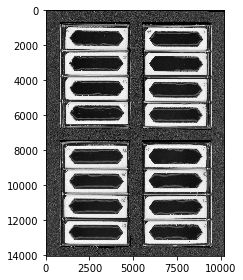

In [23]:

prefix = '07212020_01'
suffix = '001'

## Load the images
pre_img, fin_img = load_image_data(image_location, prefix, suffix)
#pre_aligned, h = alignImages(fin_image, pre_image)

io.imshow(pre_img)

#### Aligning the post image to the pre image

In [25]:
plate_id = 'SUG_012'
well_id = 'S'
slot_id = 4

In [26]:
fin_aligned, h = alignImages(pre_img, fin_img)
#io.imshow(fin_aligned)

#### Cropping to a single plate

Pre Image Dims: (6026, 4004) and Fin Image Dims: (6026, 4004)


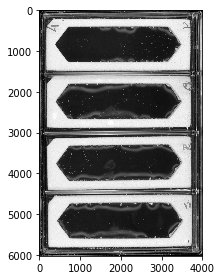

In [27]:
pre_cropped_2plate, fin_cropped_2plate = crop_to_one_plate(pre_img, fin_aligned, slot_id) 
io.imshow(fin_cropped_2plate)
print('Pre Image Dims: ' + str(pre_cropped_2plate.shape) + ' and Fin Image Dims: ' + str(fin_cropped_2plate.shape))
#cv2.imwrite(plate_id + 'cropped_2plate.tif', fin_cropped_2plate)

#### Cropping to a single well

Pre Image Dims: (1150, 3424) and Fin Image Dims: (1150, 3424)


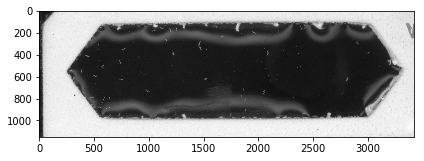

In [54]:

pre_cropped_2well, fin_cropped_2well = right_crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id) 
print('Pre Image Dims: ' + str(pre_cropped_2well.shape) + ' and Fin Image Dims: ' + str(fin_cropped_2well.shape))
io.imshow(fin_cropped_2well)

#### Subtracting the background

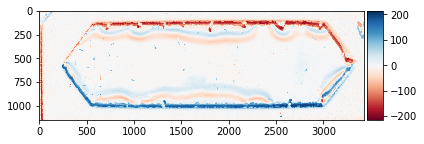

In [67]:
bkg_subtract = np.subtract(fin_cropped_2well.astype('int16'), pre_cropped_2well.astype('int16'))
io.imshow(bkg_subtract)

/Users/emilyfryer/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


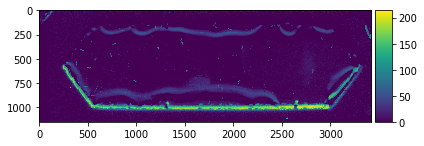

In [68]:
bkg_subtract[bkg_subtract < 0] = 0
#bkg_subtract = abs(bkg_subtract)
io.imshow(bkg_subtract)

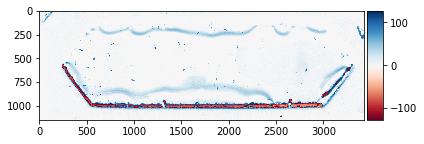

In [59]:
#bkg_subtract = bkg_subtract.astype('int8')
#io.imshow(bkg_subtract)

66


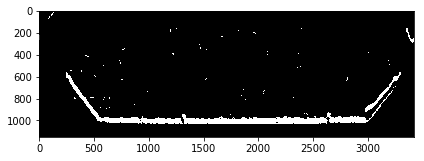

In [69]:
thresh = skimage.filters.threshold_otsu(bkg_subtract)
binarized = bkg_subtract > thresh
io.imshow(binarized)
print(thresh)

SUG_012
35


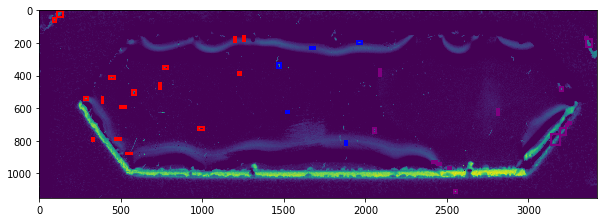

In [75]:

## Find features in binary image
labeled_array, num_features = ndi.label(binarized)
all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_cropped_2well,
                                  coordinates='rc')

## Filter features
filtered_regions = []
for region in all_regions:
    area = region.area
    if area >= 120 and area <=1000 and region.major_axis_length < 120:
        filtered_regions.append(region)

props = ['area', 'convex_area', 'bbox', 'centroid']
region_df = pd.DataFrame([{prop: getattr(reg, prop) for prop in props} for reg in filtered_regions])


            
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(bkg_subtract)

left_area_boundary = int(2*binarized.shape[1]/5)
right_area_boundary = int(3 * (binarized.shape[1] / 5))
left_side_worms = region_df[[centroid[1] <= left_area_boundary 
                                    for centroid in region_df['centroid']]]
middle_worms = region_df[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
                                 for centroid in region_df['centroid']]]
right_side_worms = region_df[[centroid[1] > right_area_boundary 
                                     for centroid in region_df['centroid']]]


for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

for index, row in middle_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    
for index, row in right_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='purple', linewidth=2)
    ax.add_patch(rect)

print(plate_id)
print(len(region_df))
# sns.scatterplot(x='X', y='Y', s=2,
#                 data=manual_analysis_results)
    
# ax.set_ylim(2000, 4000)
# ax.set_xlim(0, 2500);
#fig.savefig('../filtered_regions.pdf')

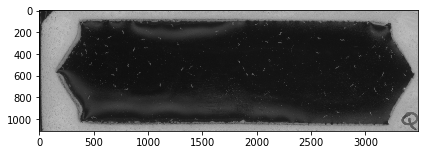

In [28]:
blur = cv2.GaussianBlur(fin_cropped_2well,(3,3),0)
io.imshow(blur)

In [29]:
pre_aligned, h = alignImages(fin_cropped_2well, pre_cropped_2well)
fin_aligned, h = alignImages(pre_aligned, fin_cropped_2well)

cv2.imwrite(plate_id + well_id + 'pre_cropped_2well.tif', pre_cropped_2well)
cv2.imwrite(plate_id + well_id + 'fin_cropped_2plate.tif', fin_cropped_2well)
cv2.imwrite(plate_id + well_id + 'fin_aligned_2well.tif', fin_aligned)
cv2.imwrite(plate_id + well_id + 'pre_aligned_2well.tif', pre_aligned)

True

In [30]:
laplacian = cv2.Laplacian(blur,cv2.CV_64F)

sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=5)

sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=5)

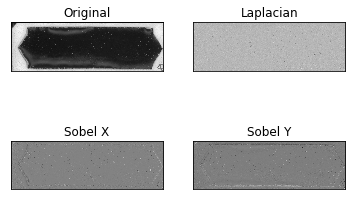

In [31]:
plt.subplot(2,2,1),plt.imshow(fin_aligned,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

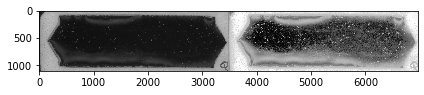

In [32]:
equ = cv2.equalizeHist(fin_cropped_2well)
res = np.hstack((fin_cropped_2well,equ)) #stacking images side-by-side
io.imshow(res)

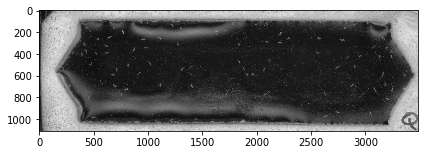

In [33]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(fin_cropped_2well)
io.imshow(cl1)

In [155]:
pre_thresh_nosub = skimage.filters.threshold_otsu(pre_aligned)
print(pre_thresh_nosub)
fin_thresh_nosub = skimage.filters.threshold_otsu(fin_aligned)
print(fin_thresh_nosub)

100
95


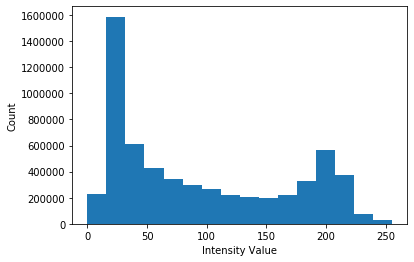

In [163]:
_ = plt.hist(cl1.ravel(), bins = 16 )
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
plt.show()

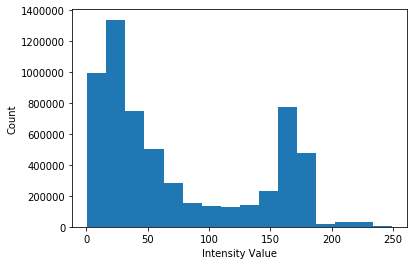

In [164]:
_ = plt.hist(fin_cropped_2well.ravel(), bins = 16 )
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Foreground')

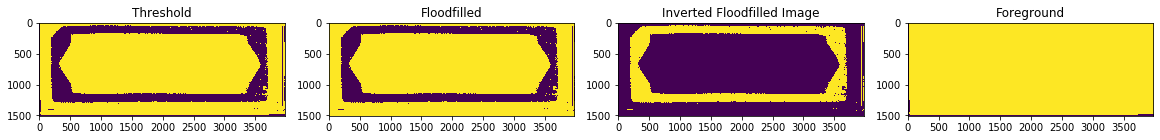

In [50]:


# Threshold.
# Set values equal to or above 220 to 0.
# Set values below 220 to 255.

th, im_th = cv2.threshold(pre_cropped_2well, 150, 255, cv2.THRESH_BINARY_INV);

# Copy the thresholded image.
im_floodfill = im_th.copy()

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Combine the two images to get the foreground.
im_out = im_floodfill_inv | im_th

# Display images.

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 8), constrained_layout=True)
axes[0].imshow(im_th)#[y_min:y_max, x_min:x_max])
axes[0].set_title('Threshold')

axes[1].imshow(im_floodfill)#[y_min:y_max, x_min:x_max])
axes[1].set_title('Floodfilled')

axes[2].imshow(im_floodfill_inv)#[y_min:y_max, x_min:x_max])
axes[2].set_title('Inverted Floodfilled Image')

axes[3].imshow(im_out)#[y_min:y_max, x_min:x_max])
axes[3].set_title('Foreground')


### Trying out Canny edge detection

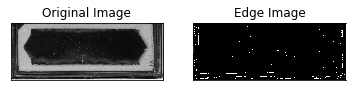

In [40]:
edges = cv2.Canny(fin_aligned,0,200)

plt.subplot(121),plt.imshow(fin_aligned,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

Pre Image Dims: (1107, 3480) and Fin Image Dims: (1107, 3480)


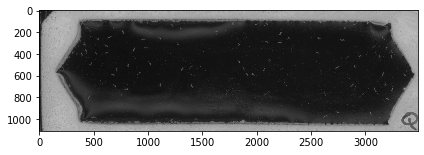

In [16]:
pre_cropped_2well, fin_cropped_2well = crop_to_one_well(pre_cropped_2plate, fin_cropped_2plate, well_id) 
print('Pre Image Dims: ' + str(pre_cropped_2well.shape) + ' and Fin Image Dims: ' + str(fin_cropped_2well.shape))
io.imshow(fin_cropped_2well)
img = fin_cropped_2well

94


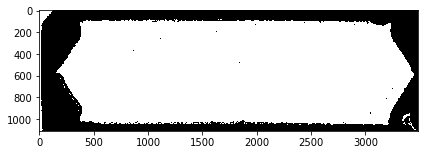

In [74]:

threshold = skimage.filters.threshold_otsu(img)
print(threshold)
binary = img < threshold
io.imshow(binary)

In [17]:

# Reading image 
#img2 = cv2.imread('arrow.jpg', cv2.IMREAD_COLOR) 


# Reading same image in another variable and 
# converting to gray scale. 
#img = cv2.imread('arrow.jpg', cv2.IMREAD_GRAYSCALE) 
#io.imshow(img)
# Converting image to a binary image 
# (black and white only image). 
_,threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
print(threshold)
print(_)
# Detecting shapes in image by selecting region 
# with same colors or intensity. 
image, contours,_=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

# Searching through every region selected to 
# find the required polygon. 
for cnt in contours : 
    area = cv2.contourArea(cnt)
    

    # Shortlisting the regions based on there area. 
    if area > 400: 
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 

        # Checking if the no. of sides of the selected region is 7. 
        if(len(approx) == 6): 
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 5) 
            print([approx])
# Showing the image along with outlined arrow. 
cv2.imshow('image', img) 

# Exiting the window if 'q' is pressed on the keyboard. 
if cv2.waitKey(0) & 0xFF == ord('q'): 
    cv2.destroyAllWindows() 


[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
110.0
[array([[[ 154,  566]],

       [[ 397,   89]],

       [[3223,  119]],

       [[3450,  586]],

       [[3192, 1055]],

       [[ 383, 1027]]], dtype=int32)]


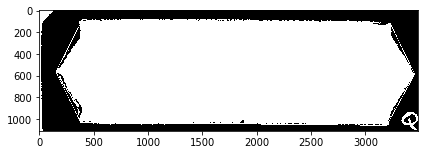

In [18]:
_,threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
img2, contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img3 = cv2.bitwise_not(img2)
io.imshow(img3)

In [61]:
_,threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)

img2, contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours
#mask = np.zeros_like(img2) # Create mask where white is what we want, black otherwise
for cnt in contours : 
    area = cv2.contourArea(cnt) 

    # Shortlisting the regions based on there area. 
    if area > 400: 
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 

        # Checking if the no. of sides of the selected region is 7. 
        if(len(approx) == 6): 
            cv2.drawContours(img2, [approx], 0, (0, 0, 255), 5) 
            

cv2.imshow('image', img2) 

# Exiting the window if 'q' is pressed on the keyboard. 
if cv2.waitKey(0) & 0xFF == ord('q'): 
	cv2.destroyAllWindows() 

In [ ]:
#cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
out = np.zeros_like(img) # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# Now crop
(y, x) = np.where(mask == 255)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = out[topy:bottomy+1, topx:bottomx+1]

# Show the output image
cv2.imshow('Output', out)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
# threshold input image using otsu thresholding as mask and refine with morphology
ret, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
kernel = np.ones((9,9), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# put thresh into 
result = img.copy()
#result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :] = mask

# save resulting masked image
cv2.imwrite('retina_masked.png', result)

True